In [1]:
#! pip install pandas

In [2]:
import os
import shutil

import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf

## Read dataset

In [3]:
# Main Directory
main_dir = 'Merged_folder/'
print(f'The total number of images is {len(os.listdir(main_dir))}')

The total number of images is 825


In [4]:
# specify the img directory path
path = main_dir

# list files in img directory
files = os.listdir(path)

image_list = []

for file in files:
    # make sure file is an image
    if file.endswith(('.jpg', '.png', 'jpeg', 'tiff')):
        #img_path = path + file
        image_list.append(os.path.join(path, file))
        
print(f'Image list top 5 examples:')
image_list[:5]

Image list top 5 examples:


['Merged_folder/73001_image_2016-10-30.tiff',
 'Merged_folder/73001_image_2016-03-20.tiff',
 'Merged_folder/73001_image_2016-08-07.tiff',
 'Merged_folder/54001_image_2016-01-24.tiff',
 'Merged_folder/73001_image_2016-06-19.tiff']

# Train-Test Split

In [5]:
# Train-Test split
image_list = np.array(image_list)
x_train, x_test = train_test_split(image_list,test_size=0.2)
#x_train, x_val = train_test_split(x_train,test_size=0.1)

In [6]:
# To numpy
x_train = np.array(x_train)
#x_val = np.array(x_val)
x_test = np.array(x_test)

# Create a custom dataloader

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for train
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)


In [8]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, image_paths,
                 batch_size,
                 input_size = (224, 224, 8),
                 shuffle = True, 
                 augmentation = None):
        
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        # Length of dataset
        self.n = len(self.image_paths)
        
    # Helper function to read the image
    def __get_image(self, path, target_size):
        # Read the image and convert to numpy array
        image = io.imread(path)
        #print(f'max {image.max()}, min: {image.min()}, type: {type(image)}')
        # Resize the image and normalize values
        image_arr = resize(image,(target_size[0], target_size[1]))
        #image_arr = tf.image.resize(image,(target_size[0], target_size[1]),method=tf.image.ResizeMethod.BILINEAR).numpy()
        #print(f'The shape of the image before reshape: {image_arr.shape}, of type{type(image_arr)}')
        #image_arr = image_arr/255.
        return image_arr
    
    def __getitem__(self, index):     
        batches = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]

        X_batch = []
        # for each image in batch
        for image_name in batches:
            # Get the image
            image = self.__get_image(image_name, self.input_size) 
            X_batch.append(image)
        
        X_batch = np.array(X_batch)
        
        # Augmentation
        if self.augmentation:
            # prepare iterator
            X_batch = self.augmentation.flow(X_batch, batch_size=self.batch_size, shuffle=True).next()
            #print('Augmentation done!')

        #print(f'The shape of the batch is : {X_batch.shape} of type: {type(X_batch)}')
        return X_batch, X_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_paths)
            
    def __len__(self):
        return self.n // self.batch_size

In [9]:
batch_size = 8
target_size = (740, 740, 12)
traingen = CustomDataGen(x_train,
                         batch_size=batch_size, 
                         input_size=target_size, 
                         augmentation=None, 
                         shuffle = True)
                         #augmentation=train_datagen)

/Users/davidrestrepo/miniforge3/envs/dengue/lib/python3.9/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3, 740, 740, 12) (12 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)


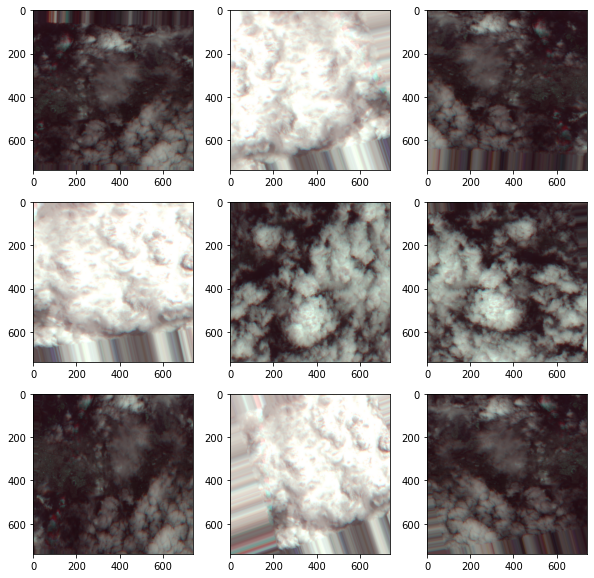

In [10]:
ax = plt. subplots(3, 3, figsize=(10,10))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generator
    example_gen = CustomDataGen(x_train,
                         batch_size=3, 
                         input_size=target_size, 
                         augmentation=train_datagen)
    # generate batch of images
    example_batch = np.array(next(zip(example_gen)))
    print(example_batch.shape)
    # Take RGB bands from first image in batch
    example_image = example_batch[0, 0, 0, :, :, 0:3]

    # plot raw pixel data
    plt.imshow(example_image)
    
# show the figure
plt.show()

# Model

In [11]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, MaxPooling2D, UpSampling2D
#from keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

## Compile the model

In [22]:
# Compile VAE
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 740, 740, 12)]    0         
                                                                 
 model (Functional)          (None, 2)                 16654020  
                                                                 
 model_1 (Functional)        (None, 740, 740, 12)      1657132   
                                                                 
Total params: 18,311,152
Trainable params: 18,311,152
Non-trainable params: 0
_________________________________________________________________


In [23]:
autoencoder.fit(traingen, epochs=20)

Epoch 1/20
Metal device set to: Apple M1


2022-05-02 13:01:50.497541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-02 13:01:50.497689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-02 13:01:50.524431: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-02 13:01:50.525346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 13:01:50.592526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 13:01:51.042575: I tensorflow/core/grappler/o

82/82 [==============================] - 464s 6s/step - batch: 40.5000 - size: 8.0000 - loss: 0.0786
Epoch 2/20
82/82 [==============================] - 358s 4s/step - batch: 40.5000 - size: 8.0000 - loss: 0.0336
Epoch 3/20
82/82 [==============================] - 345s 4s/step - batch: 40.5000 - size: 8.0000 - loss: 0.0326
Epoch 4/20
 8/82 [=>............................] - ETA: 4:42 - batch: 3.5000 - size: 8.0000 - loss: 0.0297

KeyboardInterrupt: 

# Test Model

In [ ]:
testgen = CustomDataGen(x_test,
                         batch_size=batch_size, 
                         input_size=target_size, 
                         augmentation=None)